In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import hdbscan
import nltk
import spacy

import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(10,8)})

np.random.seed(42)
%config Completer.use_jedi = False
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_rows', 100)

spaci = spacy.load("en_core_web_sm")

In [2]:
df = pd.read_csv('mindvalley_fb_comments.csv')
df.head()

Unnamed: 0                                            comment
0           0  After this class you'll see why Silicon Valley...
1           1  The shirt is almost identical to my moms fancy...
2           2  When you buy a program,  can you stop, backup,...
3           3  Exactly what is lucid dreaming? Thank you for ...
4           4  I have lucid dreams all the time, also have ov...

In [3]:
df.comment.replace("_" , " ", regex=True, inplace = True)
df.comment.replace("^" , " ", regex=True, inplace = True)

In [4]:
df.comment.head()

0     After this class you'll see why Silicon Valle...
1     The shirt is almost identical to my moms fanc...
2     When you buy a program,  can you stop, backup...
3     Exactly what is lucid dreaming? Thank you for...
4     I have lucid dreams all the time, also have o...
Name: comment, dtype: object

In [5]:
import string
for punc in string.punctuation:
    try:
        df.comment.replace(f"\{punc}", "", regex=True, inplace = True)
    except:
        pass

In [6]:
df.comment[0]

' After this class youll see why Silicon Valley companies are flocking to trainers like Charlie to be the first to start utilising this unexplored frontier of personal growth\n‚†Ä\nüëÜ Check out this link to get started httpsgomindvalleycompfrc94E8\n\nSweet Dreams üí§üí§üí§'

In [7]:
junk_words = "tqvm yessssssssssit youuuuuu nan nt citi kashif a very were yet than through via here rishisunak more much getting go going ive dont able when which who year barclays hsbcin amp like an no any since after banking im there out how starlingbank starling one only again over other then am may some do cant about banks would could its even their after has them get got within now all just if what or at had hsbcukbusiness up by into will an was our us so been hsbcuk co om ke ha gone your we can from as but to the hsbc and of you for are have they is my hsbc_uk with it in on this √∞√ø be not bank me that"
junk_words_list = junk_words.split(" ")

In [8]:
def remove_unicode(text):

    try:
        text = text.encode("latin_1").decode("raw_unicode_escape").encode('utf-16', 'surrogatepass').decode('utf-16')
    except:
        text = text

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", re.UNICODE)

    text = re.sub(emoji_pattern, '', str(text))
    text = ''.join(text.split('\\n')) # to remove uncompiled \n
    text = re.sub('\n', '', text)     # to remove compiled \n

    return text

In [9]:
def clean_data(text, small_word_lmt=2, extra_words=junk_words_list):
    list_data2=[]
    text = remove_unicode(text)
    sentence=text.lower().split(' ')
    for word in sentence:
        if word == "hi":
            word = word.replace("hi", "hello")
        if not word.startswith('http') \
           and word.isalpha() \
           and len(word)>small_word_lmt \
           and word not in extra_words:
            list_data2.append(word)
    return " ".join(list_data2)
df.comment = df.comment.apply(lambda x: clean_data(x))

In [10]:
df.comment[0]

'class youll see why silicon valley companies flocking trainers charlie first start utilising unexplored frontier personal growth check link started dreams'

In [11]:
def word_root(text):
    list_data3=[]
    
    doc = spaci(text)
    for token in doc:
        lemma = token.lemma_
        if lemma != "do":
            list_data3.append(lemma)
        else:pass
    return " ".join(list_data3)
df.comment = df.comment.apply(lambda x: word_root(x))  

In [12]:
df.comment[0]

'class you ll see why silicon valley company flock trainer charlie first start utilise unexplored frontier personal growth check link start dream'

In [13]:
# adjustment for non-english words

# nltk.download('words')
# eng_words = set(nltk.corpus.words.words())
# df["eng"] = df.tweet.apply(lambda x: " ".join([i for i in nltk.wordpunct_tokenize(x) if i in eng_words]))
# df["noneng"] = df.tweet.apply(lambda x: " ".join([i for i in nltk.wordpunct_tokenize(x) if i not in eng_words]))
# df.noneng.tolist()

In [14]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in df.comment])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(20)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [15]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in df.comment])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(20)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

In [16]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [17]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

ValueError: Length mismatch: Expected axis has 0 elements, new values have 2 elements

In [ ]:
bigrams = [' '.join(x) for x in bigram_pmi.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in trigram_pmi.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [ ]:
bigrams

In [ ]:
trigrams

In [18]:
replace_ngrams = {"thank you for":"thank_you_for", "happy birthday":"happy_birthday"}
for key, value in replace_ngrams.items():
    df.comment.replace(f"\S*{key}\S*" , f"{value} "*3, regex=True, inplace = True)
    

In [19]:
# replace_key_words = ['delay', 'wait', 'on_hold', 'any_news', 'awful', 'disappointed', 'give_up', 'regret', 'worse', 'worst', 'unhappy', 'sucksunbelievable', 'frustrated', 'disgusted', 'happy', 'disgrace', 'awesome', 'fantastic', 'well_done', 'great', 'leave', 'bye', 'switch', 'covidenvironment', 'fossil', 'coal', 'fuel', 'climate', 'carbon', 'best', 'wonderfull']
# for key_word in replace_key_words:
#     df.tweet.replace(f"\S*{key_word}\S*" , f"{key_word} "*2, regex=True, inplace = True)


In [20]:
# df.drop(df[df.tweet.str.contains("tatacrucible")].index, axis=0,inplace=True)

In [21]:
df_clean = df.comment
df_clean.shape

(1244,)

In [22]:
df_clean = df_clean.dropna()
df_clean.shape

(1244,)

In [23]:
list_data = df_clean.to_list()
list_data = [str(sent) for sent in list_data]

In [24]:
from sentence_transformers import SentenceTransformer

In [25]:
# distilbert-base-nli-mean-tokens
# paraphrase-distilroberta-base-v1

In [26]:
model=SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings1 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/39 [00:00<?, ?it/s]

In [27]:
# embeddings1[embeddings1.argmax()]

In [28]:
model=SentenceTransformer('paraphrase-distilroberta-base-v1')
embeddings2 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/39 [00:00<?, ?it/s]

In [29]:
embeddings1_norm = embeddings1 /  np.linalg.norm(embeddings1, axis=1, keepdims=True)
embeddings2_norm = embeddings2 /  np.linalg.norm(embeddings2, axis=1, keepdims=True)

In [30]:
import umap

In [31]:
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE

In [32]:
UMAP_bert1 = umap.UMAP(n_components=2).fit_transform(embeddings1)
UMAP_bert1_norm = umap.UMAP(n_components=2).fit_transform(embeddings1_norm)

UMAP_bert2 = umap.UMAP(n_components=2).fit_transform(embeddings2)
UMAP_bert2_norm = umap.UMAP(n_components=2).fit_transform(embeddings2_norm)

#n_neighbors=10, min_dist=0.0, 

In [33]:
PCA_bert1 = PCA(n_components=2).fit_transform(embeddings1)
PCA_bert1_norm = PCA(n_components=2).fit_transform(embeddings1_norm)

PCA_bert2 = PCA(n_components=2).fit_transform(embeddings2)
PCA_bert2_norm = PCA(n_components=2).fit_transform(embeddings2_norm)

In [34]:
tSNE_bert1 = TSNE(n_components=2).fit_transform(embeddings1)
tSNE_bert1_norm = TSNE(n_components=2).fit_transform(embeddings1_norm)

tSNE_bert2 = TSNE(n_components=2).fit_transform(embeddings2)
tSNE_bert2_norm = TSNE(n_components=2).fit_transform(embeddings2_norm)

In [35]:
from pyclustertend import hopkins
hopkins(UMAP_bert2,UMAP_bert2.shape[0])

0.006110387307165632

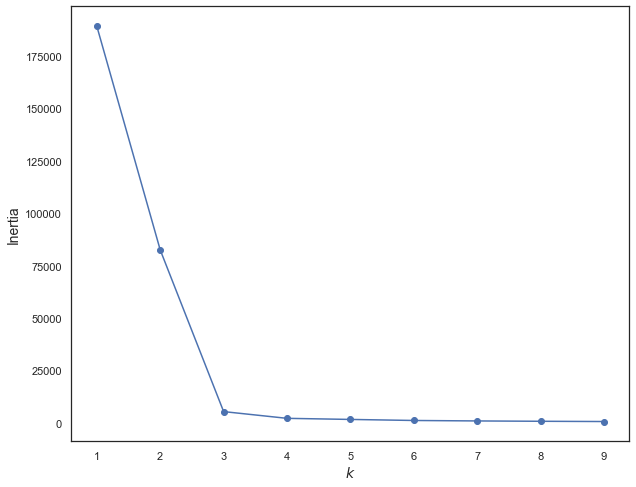

In [36]:
#inertia

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(UMAP_bert2)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [37]:
def cluster_results(Kmeans_clusters=4):
    
    ClusterDict = {}
    dim_embeddings = {"UMAP_bert1" : UMAP_bert1, "UMAP_bert1_norm" : UMAP_bert1_norm, 
                      "UMAP_bert2" : UMAP_bert2, "UMAP_bert2_norm" : UMAP_bert2_norm,
                      "PCA_bert1" : PCA_bert1, "PCA_bert1_norm" : PCA_bert1_norm, 
                      "PCA_bert2" : PCA_bert2, "PCA_bert2_norm" : PCA_bert2_norm,
                      "tSNE_bert1" : tSNE_bert1, "tSNE_bert1_norm" :  tSNE_bert1_norm, 
                      "tSNE_bert2" : tSNE_bert2, "tSNE_bert2_norm" : tSNE_bert2_norm}
    
    for key, val in dim_embeddings.items():
        ClusterDict[key] = KMeans(n_clusters=Kmeans_clusters).fit_predict(val)
        ClusterDict[key+"_hdbscan"] = hdbscan.HDBSCAN(min_samples = 30,
                           min_cluster_size=15,
                           metric = 'euclidean',
                           cluster_selection_epsilon = 0.25,
                           cluster_selection_method = "eom").fit_predict(val)
    return ClusterDict

In [38]:
clustering_result = cluster_results()

In [39]:
def plot(cluster = clustering_result):    
    reduced_dims = {"UMAP_bert1" : UMAP_bert1, "UMAP_bert1_norm" : UMAP_bert1_norm, 
                    "UMAP_bert2" : UMAP_bert2, "UMAP_bert2_norm" : UMAP_bert2_norm,
                    "PCA_bert1" : PCA_bert1, "PCA_bert1_norm" : PCA_bert1_norm, 
                    "PCA_bert2" : PCA_bert2, "PCA_bert2_norm" : PCA_bert2_norm,
                    "tSNE_bert1" : tSNE_bert1, "tSNE_bert1_norm" :  tSNE_bert1_norm, 
                    "tSNE_bert2" : tSNE_bert2, "tSNE_bert2_norm" : tSNE_bert2_norm,
                    "UMAP_bert1_hdbscan" : UMAP_bert1, "UMAP_bert1_norm_hdbscan" : UMAP_bert1_norm, 
                    "UMAP_bert2_hdbscan" : UMAP_bert2, "UMAP_bert2_norm_hdbscan" : UMAP_bert2_norm,
                    "PCA_bert1_hdbscan" : PCA_bert1, "PCA_bert1_norm_hdbscan" : PCA_bert1_norm, 
                    "PCA_bert2_hdbscan" : PCA_bert2, "PCA_bert2_norm_hdbscan" : PCA_bert2_norm,
                    "tSNE_bert1_hdbscan" : tSNE_bert1, "tSNE_bert1_norm_hdbscan" :  tSNE_bert1_norm, 
                    "tSNE_bert2_hdbscan" : tSNE_bert2, "tSNE_bert2_norm_hdbscan" : tSNE_bert2_norm}

    for clustee_name, clustee in cluster.items():
        clustered = (clustee >= 0)
        reduced_dim = reduced_dims[clustee_name]
            
        print(f"----------{clustee_name}--------------------")

        unique, counts = np.unique(clustee, return_counts=True)
        print(dict(zip(unique, counts)))

        plt.scatter(reduced_dim[~clustered, 0],
                    reduced_dim[~clustered, 1],
                    c=(0.5,0.5,0.5),
                    # s=1,
                    alpha=0.5
                    )
        plt.scatter(reduced_dim[clustered, 0],
                    reduced_dim[clustered, 1],
                    c=clustee[clustered],
                    # s=1,
                    cmap='Spectral')
        plt.show()

----------UMAP_bert1--------------------
{0: 438, 1: 606, 2: 124, 3: 76}


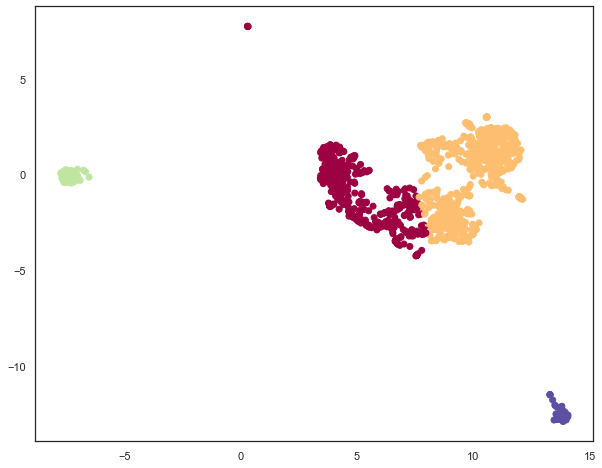

----------UMAP_bert1_hdbscan--------------------
{0: 124, 1: 76, 2: 1044}


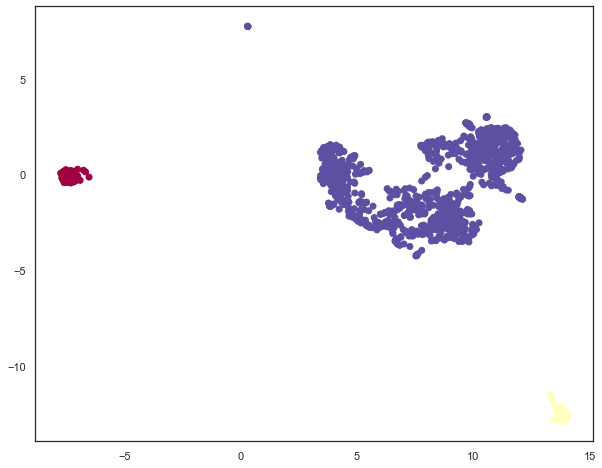

----------UMAP_bert1_norm--------------------
{0: 538, 1: 77, 2: 507, 3: 122}


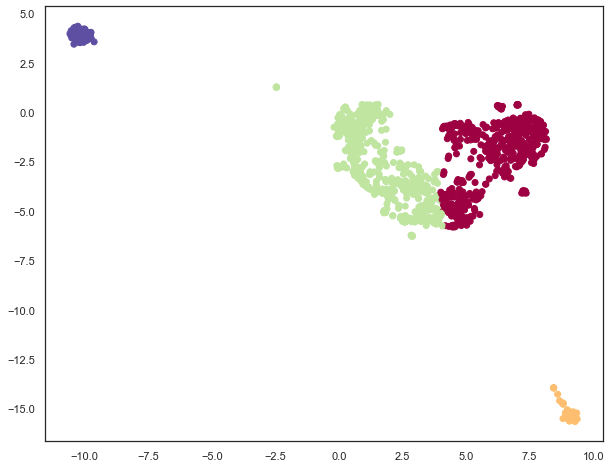

----------UMAP_bert1_norm_hdbscan--------------------
{0: 77, 1: 122, 2: 1045}


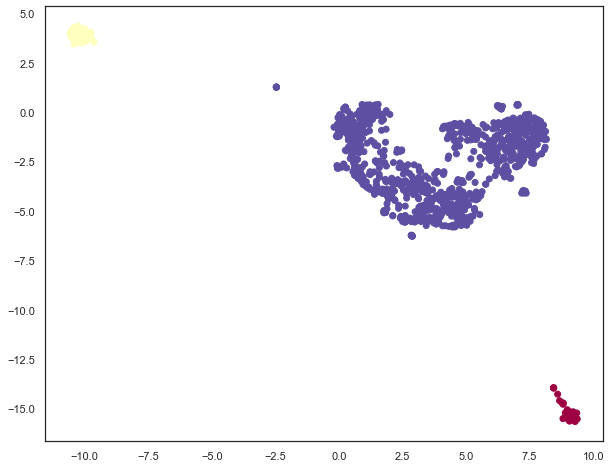

----------UMAP_bert2--------------------
{0: 531, 1: 94, 2: 113, 3: 506}


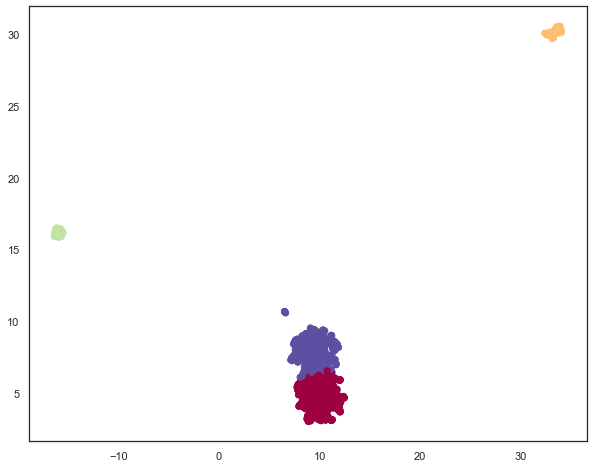

----------UMAP_bert2_hdbscan--------------------
{0: 94, 1: 113, 2: 1037}


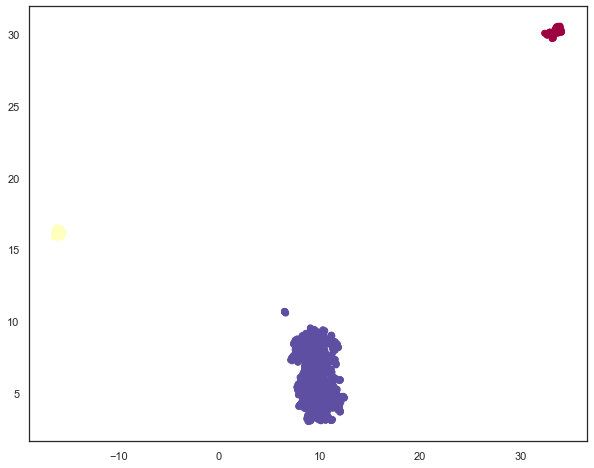

----------UMAP_bert2_norm--------------------
{0: 392, 1: 622, 2: 135, 3: 95}


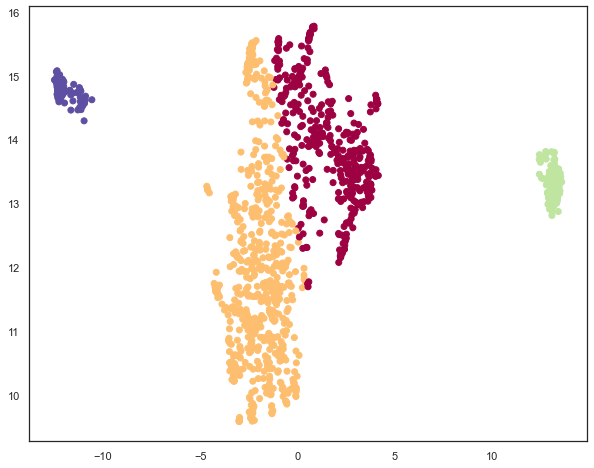

----------UMAP_bert2_norm_hdbscan--------------------
{0: 135, 1: 95, 2: 1014}


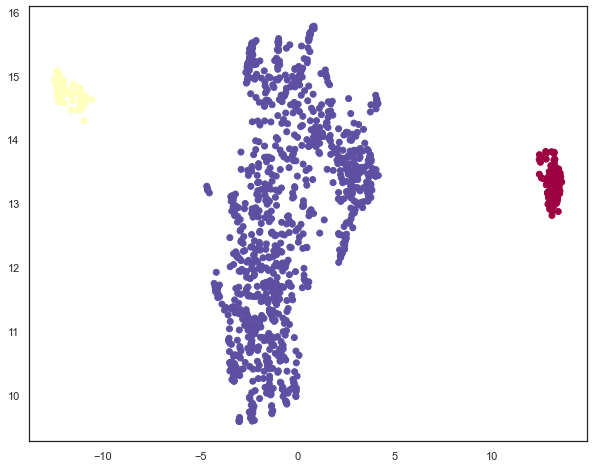

----------PCA_bert1--------------------
{0: 322, 1: 353, 2: 331, 3: 238}


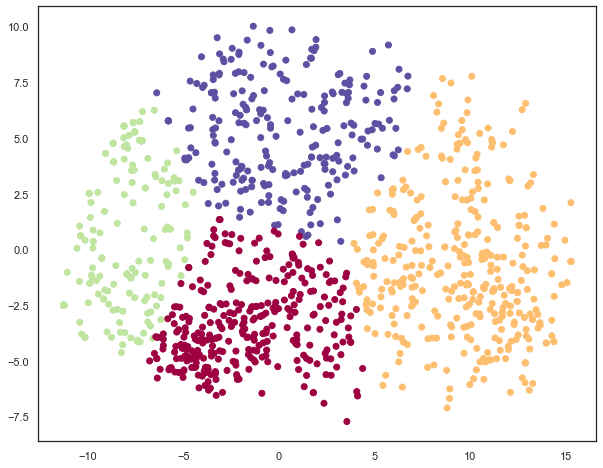

----------PCA_bert1_hdbscan--------------------
{-1: 667, 0: 103, 1: 45, 2: 102, 3: 121, 4: 206}


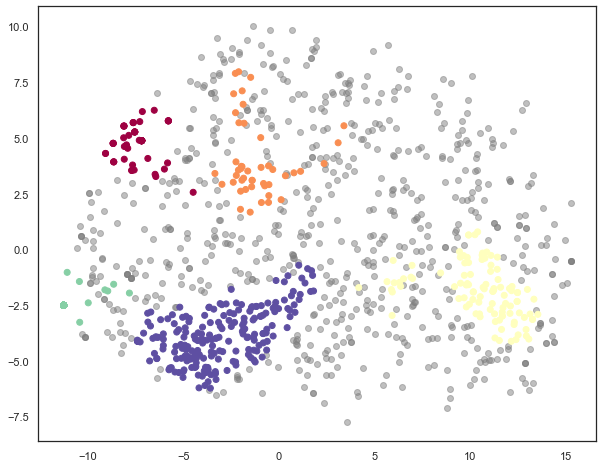

----------PCA_bert1_norm--------------------
{0: 237, 1: 343, 2: 346, 3: 318}


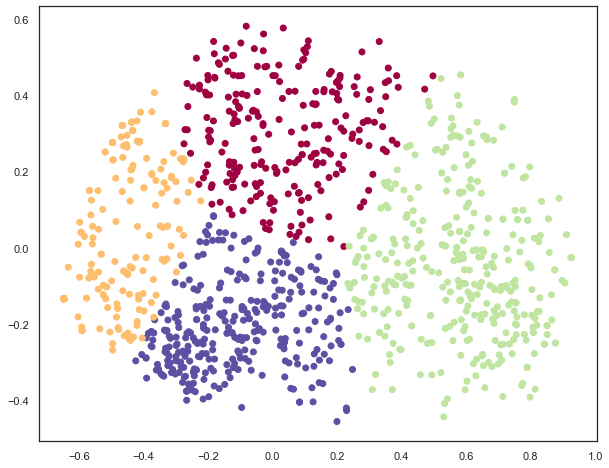

----------PCA_bert1_norm_hdbscan--------------------
{-1: 511, 0: 101, 1: 632}


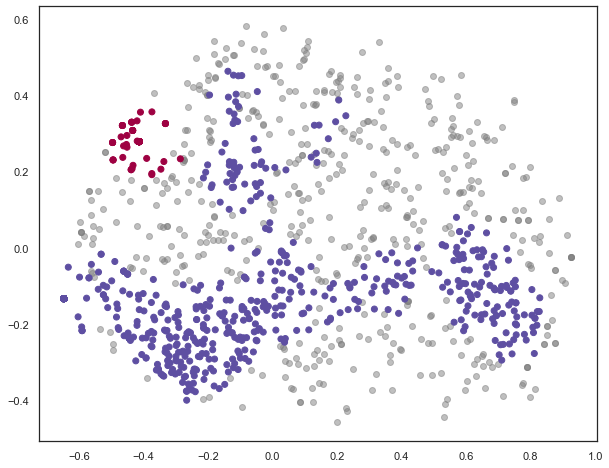

----------PCA_bert2--------------------
{0: 677, 1: 113, 2: 362, 3: 92}


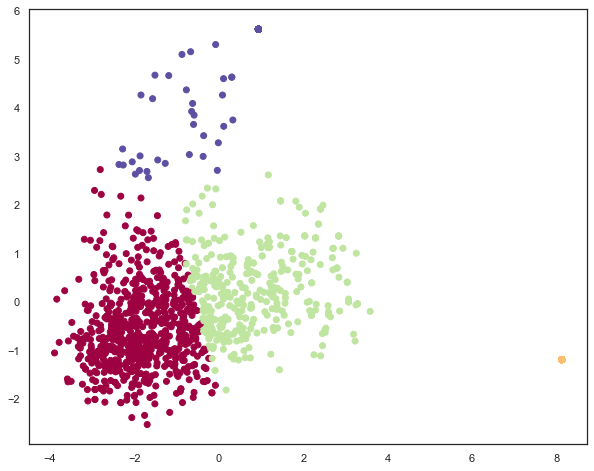

----------PCA_bert2_hdbscan--------------------
{-1: 21, 0: 113, 1: 63, 2: 1047}


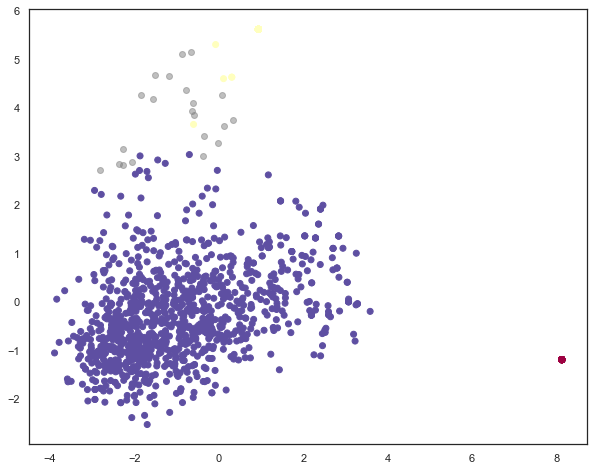

----------PCA_bert2_norm--------------------
{0: 82, 1: 345, 2: 698, 3: 119}


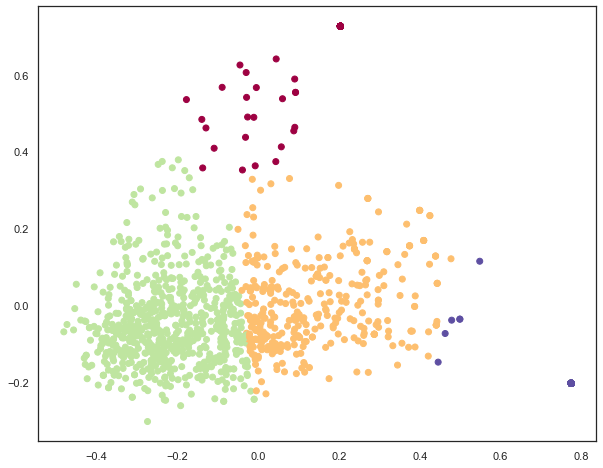

----------PCA_bert2_norm_hdbscan--------------------
{0: 113, 1: 1131}


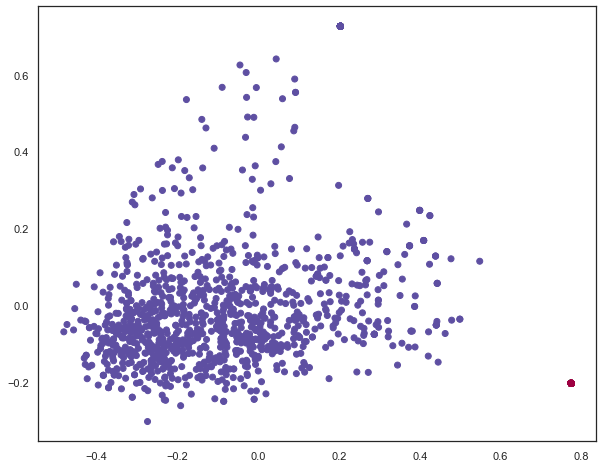

----------tSNE_bert1--------------------
{0: 226, 1: 393, 2: 381, 3: 244}


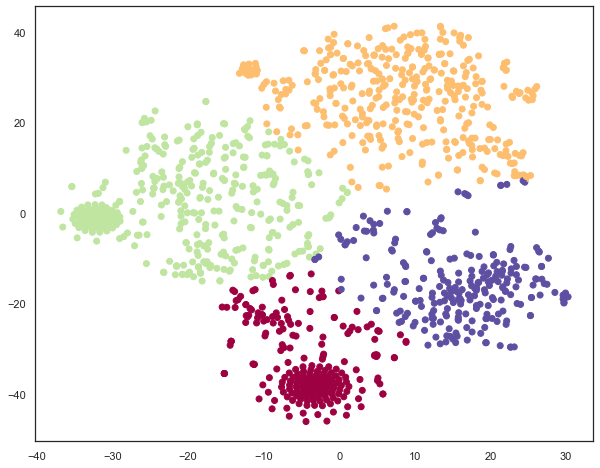

----------tSNE_bert1_hdbscan--------------------
{-1: 426, 0: 187, 1: 330, 2: 112, 3: 31, 4: 58, 5: 62, 6: 38}


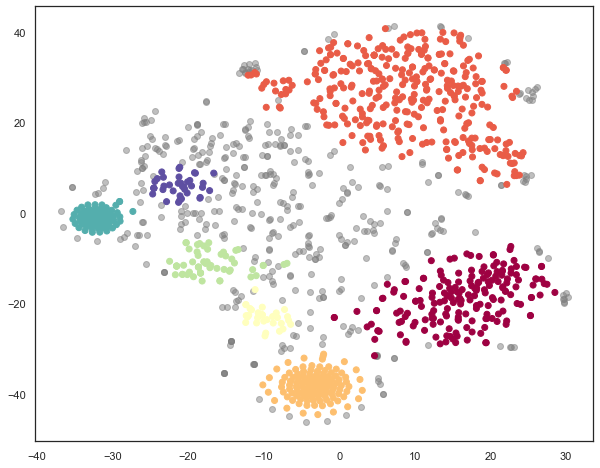

----------tSNE_bert1_norm--------------------
{0: 390, 1: 228, 2: 271, 3: 355}


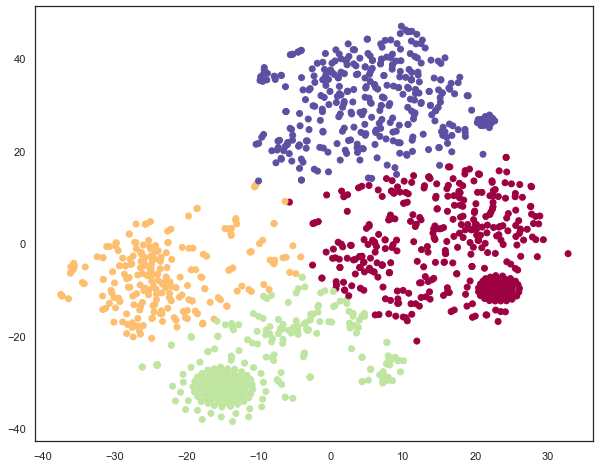

----------tSNE_bert1_norm_hdbscan--------------------
{-1: 517, 0: 288, 1: 136, 2: 112, 3: 22, 4: 42, 5: 64, 6: 63}


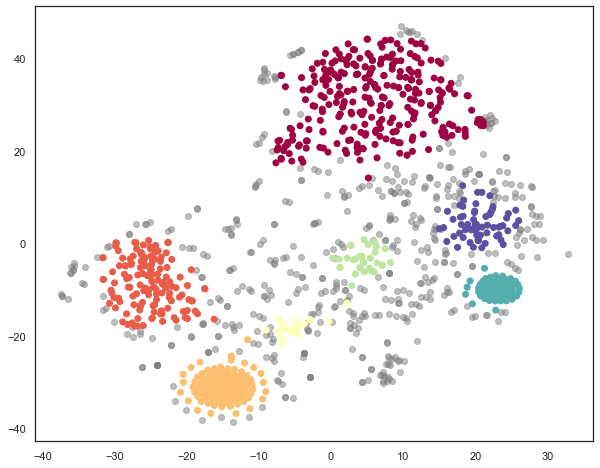

----------tSNE_bert2--------------------
{0: 348, 1: 504, 2: 113, 3: 279}


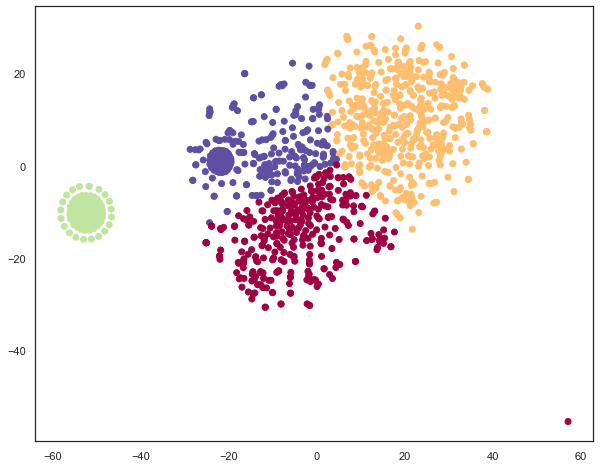

----------tSNE_bert2_hdbscan--------------------
{-1: 1, 0: 113, 1: 1130}


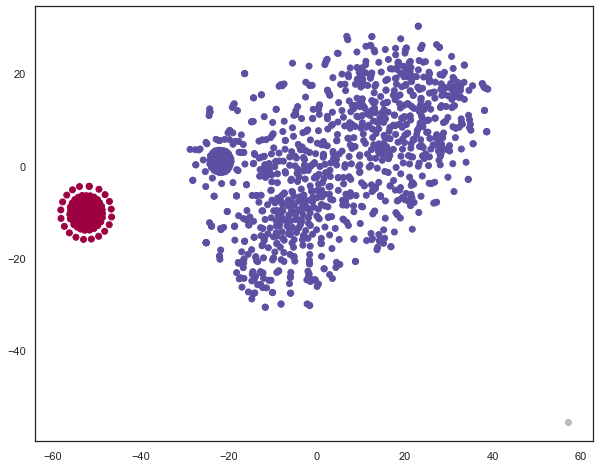

----------tSNE_bert2_norm--------------------
{0: 188, 1: 406, 2: 386, 3: 264}


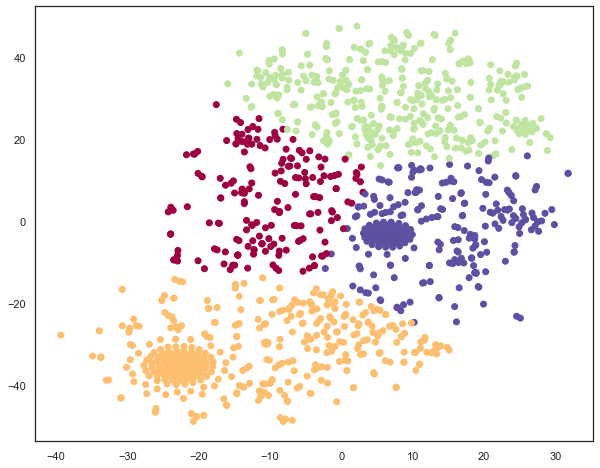

----------tSNE_bert2_norm_hdbscan--------------------
{-1: 571, 0: 31, 1: 103, 2: 132, 3: 287, 4: 85, 5: 35}


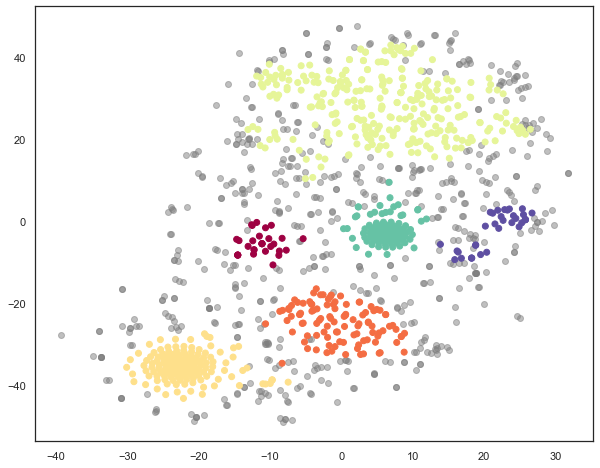

In [40]:
plot()

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidfmatrix(data, vectorizer):
    terms = vectorizer.fit_transform(data)
    return pd.DataFrame(terms.toarray(), columns = vectorizer.get_feature_names())

In [42]:
def cluster_words(clustering_result=clustering_result, top_n = 20):
    for name, value in clustering_result.items():
        print(f"===================================={name}=============================================")
    
        #creatin new df in order to groupby same clusters
        cluster = value
        docs = pd.DataFrame(df_clean)
        docs["cluster"] = cluster

        labeled_docs = docs.groupby(["cluster"], as_index=False).agg({"comment": " ".join})
                
        tfidf_vec = TfidfVectorizer(max_df=0.85)
        tfidf_mat = tfidfmatrix(labeled_docs.comment, tfidf_vec)
        
        global most_common
        most_common = pd.DataFrame({n: tfidf_mat.T[col].nlargest(top_n).index.tolist() 
                                for n, col in enumerate(tfidf_mat.T)}).T
        most_common.index = np.unique(cluster)
        display(most_common)

In [43]:
cluster_words()

====================================UMAP_bert1=============================================


0               1       2                3             4       5   \
0  mindvalley           great  access              yes           por    good   
1        love  happy_birthday   thank             life          help  people   
2       level           limit    tack  variousposition       control   voice   
3       thank            amen     aha       appreciate  appreciation   bless   

               6        7            8       9        10        11       12  \
0           hello      que          say   think     true      want      jes   
1            know    learn         want  vishen     good      make  because   
2         between     spot       vishen      ab  abandon     abdel  abigail   
3  congratulation  forgive  forgiveness     god      sir  strength  welcome   

         13          14        15          16           17      18          19  
0      mind         way  moodliar  pennington       always    know        life  
1      come  mindvalley       see        food  masterclass   never        take  
2   abijith     ability      abit       above   absolutely  absorb  absorption  
3  yourself     arigato    follow        hard       moment    need      really

====================================UMAP_bert1_hdbscan=============================================


0      1       2                3             4        5      6   \
0  level  limit    tack  variousposition       between  control   spot   
1  thank   amen     aha       appreciate  appreciation  arigato  bless   
2   love   life  people             know          help    thank   want   

               7       8        9            10              11       12  \
0          vishen   voice       ab      abandon           abdel  abigail   
1  congratulation  follow  forgive  forgiveness             god     hard   
2            good   learn   vishen   mindvalley  happy_birthday     make   

        13       14      15        16          17      18          19  
0  abijith  ability    abit     above  absolutely  absorb  absorption  
1   moment     need  really  reminder       right     sir    strength  
2      say      see    take       new        find     she        time

====================================UMAP_bert1_norm=============================================


0               1           2                3             4   \
0         love  happy_birthday       thank             help          life   
1        thank            amen         aha             monk  appreciation   
2        great            good  mindvalley             mind        access   
3  inspiraci√≥n           limit        tack  variousposition         voice   

        5            6       7         8        9         10          11  \
0   people         know   learn      want   vishen      make        good   
1    bless  forgiveness     sir  strength  welcome  yourself  appreciate   
2     work         know  listen     think     want       yes         por   
3  between      control    spot    vishen       ab   abandon       abdel   

        12              13          14           15     16          17  \
0  because            come  mindvalley  masterclass  never         see   
1  arigato  congratulation      follow      forgive    god        hard   
2   always         amazing       hello         life    que         say   
3  abigail         abijith     ability         abit  above  absolutely   

       18          19  
0     new         say  
1  moment        name  
2    true         way  
3  absorb  absorption

====================================UMAP_bert1_norm_hdbscan=============================================


0      1       2                3           4             5   \
0        thank   amen     aha             monk  appreciate  appreciation   
1  inspiraci√≥n  limit    tack  variousposition     between       control   
2         love   life  people             know        help         thank   

        6       7               8       9           10              11  \
0  arigato   bless  congratulation  follow     forgive     forgiveness   
1     spot  vishen           voice      ab     abandon           abdel   
2     want    good           learn  vishen  mindvalley  happy_birthday   

        12       13       14    15     16          17      18          19  
0      god     hard   moment  name   need      please  really    reminder  
1  abigail  abijith  ability  abit  above  absolutely  absorb  absorption  
2     make      say      see  take    new        find     she        time

====================================UMAP_bert2=============================================


0        1               2        3          4        5       6      7   \
0  learn     life  happy_birthday     help     people     want  vishen   make   
1  thank    share          always    bless       love   really    work    god   
2     ab  abandon           abdel  abigail    abijith  ability    abit  above   
3   love    great            good      que  beautiful     such   happy     he   

           8       9           10      11          12        13       14  \
0  mindvalley    know        mind   thank       sugar      come      see   
1    grateful  remind     welcome  enough  everything      hear     need   
2  absolutely  absorb  absorption     abt   abundance  abundant    abuse   
3        want     por     arigato   hello        true       jes  amazing   

            15        16          17         18        19  
0  masterclass      take        time     change      find  
1         nice  reminder      vishen       well      word  
2       abused    abuser      accent     accept  accepted  
3          say    vishen  incredible  interview       new

====================================UMAP_bert2_hdbscan=============================================


0        1       2        3        4        5       6           7   \
0  thank    share  always    bless     love   really    work      enough   
1     ab  abandon   abdel  abigail  abijith  ability    abit       above   
2   life   people    help     want    learn     love  vishen  mindvalley   

               8       9           10     11         12        13      14  \
0      everything     god    grateful   hear       need      nice  remind   
1      absolutely  absorb  absorption    abt  abundance  abundant   abuse   
2  happy_birthday    make        know  thank       good       see    take   

         15      16       17      18        19  
0  reminder  vishen  welcome    well      word  
1    abused  abuser   accent  accept  accepted  
2       new    find      she    time      mind

====================================UMAP_bert2_norm=============================================


0      1       2     3               4       5       6      7   \
0  great    que    good   por            true     jes     his    yes   
1  learn   love  vishen  life  happy_birthday  people    help   want   
2   anna  birth    hawk  moss             pcj  rabbit     sea  shero   
3  thank  share    need  hope            love    hear  really    big   

         8           9           10       11        12      13          14  \
0  moodliar  pennington        want  amazing     hello    nice     lorenza   
1       new  mindvalley        make    thank      know    mind       sugar   
2      bull        cost       exist     hard      john    life  meditation   
3     bless      enough  experience      god  grateful  remind     welcome   

        15     16          17          18           19  
0   action   amen          he  incredible    interview  
1     come    see         day        food  masterclass  
2  purpose  super     between    daughter      program  
3   always   book  everything        nice     reminder

====================================UMAP_bert2_norm_hdbscan=============================================


0       1     2      3     4           5               6       7   \
0    anna   birth  hawk   moss   pcj      rabbit             sea   shero   
1   thank   share  need   hear  hope        love          really  always   
2  vishen  people  want  learn  love  mindvalley  happy_birthday    make   

        8      9     10        11          12          13    14        15  \
0  between   bull  cost  daughter       exist        hard  john      life   
1      big  bless  book    enough  everything  experience   god  grateful   
2     life   know  help     thank        good         see  take       new   

           16       17        18       19  
0  meditation  program   purpose     spot  
1        nice   remind  reminder  welcome  
2        find      she      time     mind

====================================PCA_bert1=============================================


0      1         2           3      4            5        6   \
0      mindvalley  think  moodliar  pennington  never        video  lorenza   
1  happy_birthday   help      come       learn   love  masterclass     week   
2            true    jes     great     amazing   amen         nice     cool   
3            love  great     happy   beautiful  share          new  amazing   

           7       8              9           10       11     12        13  \
0     forgive     she           find       human   listen   mind    please   
1       sugar     see           food  mindvalley     take  every       try   
2  absolutely  action  extraordinary      indeed  inspire  level  profound   
3        mind   lucid          dream  mindvalley  healthy   kind  lakhiani   

        14         15       16       17        18      19  
0   create     martin     miss     name       bbw  grazie  
1    fruit       find    these  because       she     new  
2    truth        aha     anna  argelio     arora  astral  
3  matthew  fantastic  sharing   enough  powerful    soul

====================================PCA_bert1_hdbscan=============================================


0        1        2        3                 4       5   \
-1  happy_birthday    thank     love     help            vishen    life   
 0           thank  amazing    great     true           awesome    cool   
 1           thank     love   listen     work  linktreepalcidus    good   
 2          people    sugar    fruit  history             learn    want   
 3            well  namaste      ohh      yep               opt  follow   
 4             jes    never  lorenza   martin               bbw  grazie   

             6           7        8         9           10          11  \
-1        learn        want     know      good         his         try   
 0         good        love     nice  profound      embody  impressive   
 1         hear  mindvalley     nice    vishen        care    everyone   
 2  masterclass        help    juice      life        need      should   
 3         spot          ab  abandon     abdel     abigail     abijith   
 4         mind        miss    think      musk  mindvalley         she   

         12          13          14          15       16          17       18  \
-1      day  mindvalley        mind         new  because      really     find   
 0    sense      upward  absolutely    equality      hug      lovely      sir   
 1  exactly    lakhiani       lucid        mean    share       dream     goal   
 2      ang      vishen     myanmar      really      see        know      san   
 3  ability        abit       above  absolutely   absorb  absorption      abt   
 4   vishen          be       hello       human     want       watch  beasley   

            19  
-1        tell  
 0  appreciate  
 1  incredible  
 2         suu  
 3   abundance  
 4      brandy

====================================PCA_bert1_norm=============================================


0      1         2           3        4          5        6   \
0            love  great     happy         new  amazing  beautiful    share   
1            true    jes      amen       great  amazing       love     nice   
2  happy_birthday   help      come       learn     week      sugar     love   
3      mindvalley  think  moodliar  pennington    never      video  lorenza   

     7         8            9           10             11       12      13  \
0  mind     lucid        dream  mindvalley           such  healthy    kind   
1  cool  profound   absolutely      action  extraordinary   follow  indeed   
2   see      food  masterclass  mindvalley           take    every     try   
3   she      find        human      listen           mind   please  create   

         14       15         16       17      18    19  
0  lakhiani  matthew  fantastic  sharing  enough  soul  
1   inspire    level      share    truth     aha  anna  
2     fruit     find      these  because     she   new  
3    martin     miss       name      bbw  grazie   kim

====================================PCA_bert1_norm_hdbscan=============================================


0       1           2      3       4         5           6   \
-1  happy_birthday  vishen        life  learn    help      know  mindvalley   
 0            cool  embody  impressive  sense  upward  equality      lovely   
 1          people    want      vishen   know   sugar      help        life   

      7      8        9       10          11       12       13    14      15  \
-1   new   mind     want  people        find      his    happy  take  really   
 0   sir     ab  abandon   abdel     abigail  abijith  ability  abit   above   
 1  need  fruit    learn     see  mindvalley      try     take  time     she   

         16           17     18         19  
-1      see          she   week    because  
 0   absorb   absorption    abt  abundance  
 1  history  masterclass  never      think

====================================PCA_bert2=============================================


0        1      2               3           4          5      6   \
0  people     help   life  happy_birthday       learn        see   want   
1      ab  abandon  abdel         abigail     abijith    ability   abit   
2    love    great    jes            true         yes  beautiful  video   
3   thank    share   love          always  mindvalley     vishen  bless   

         7           8       9           10      11         12  \
0    vishen        make    find        know     try      thank   
1     above  absolutely  absorb  absorption     abt  abundance   
2      want        nice   happy       hello    good    amazing   
3  lakhiani        need  remind        hear  really        aha   

               13       14        15        16      17          18          19  
0            mind     love   because     sugar     say        come          nt  
1        abundant    abuse    abused    abuser  accent      accept    accepted  
2         awesome      his      read       way     bbw      grazie  passionate  
3  beautifulthank  earning  gratitud  thankful  thanks  appreciate         big

====================================PCA_bert2_hdbscan=============================================


0        1           2         3        4        5       6        7   \
-1  thank     love      always      hear     need   really  vishen     well   
 0     ab  abandon       abdel   abigail  abijith  ability    abit    above   
 1  thank    share  appreciate  reminder    right     work      ab  abandon   
 2   life   people        know      help     want     good   learn     love   

            8           9               10       11         12        13  \
-1  advancewow         aha  beautifulthank  earning   gratitud  thankful   
 0  absolutely      absorb      absorption      abt  abundance  abundant   
 1       abdel     abigail         abijith  ability       abit     above   
 2      vishen  mindvalley  happy_birthday     make        say       see   

            14      15          16      17         18        19  
-1      thanks    amen    american   bless    destroy    enough  
 0       abuse  abused      abuser  accent     accept  accepted  
 1  absolutely  absorb  absorption     abt  abundance  abundant  
 2       thank    take         new    find        she      time

====================================PCA_bert2_norm=============================================


0     1       2     3               4      5               6   \
0   thank  love   share  hear      mindvalley    aha  beautifulthank   
1   great  love     jes   yes       beautiful   want            nice   
2  people  help  vishen  life  happy_birthday   know           learn   
3    true  bull   right    ab         abandon  abdel         abigail   

         7        8           9      10          11       12          13  \
0  gratitud   thanks  appreciate    big       bless  brother     germany   
1   amazing    hello       video   good        true  awesome       happy   
2       see     want       thank   make        find      try        love   
3   abijith  ability        abit  above  absolutely   absorb  absorption   

     14         15        16      17       18       19  
0  glad        god      keep  moment     poem  siempre  
1   his       read       bbw    amen  arigato     book  
2  mind    because     sugar     say     come       nt  
3   abt  abundance  abundant   abuse   abused   abuser

====================================PCA_bert2_norm_hdbscan=============================================


0        1       2        3        4        5     6      7           8   \
0     ab  abandon   abdel  abigail  abijith  ability  abit  above  absolutely   
1  thank     love  vishen     life   people     know  help   want        good   

       9           10              11         12        13     14      15  \
0  absorb  absorption             abt  abundance  abundant  abuse  abused   
1   learn  mindvalley  happy_birthday       make       say    see    need   

       16      17      18        19  
0  abuser  accent  accept  accepted  
1    take     new    find       she

====================================tSNE_bert1=============================================


0      1     2         3           4       5            6   \
0             jes   true   yes      amen        bull     leo          pan   
1  happy_birthday  learn  help    people        come  vishen  masterclass   
2           thank   love  good     great      vishen   happy    beautiful   
3      mindvalley    por   que  moodliar  pennington  vishen      lorenza   

      7        8           9       10     11      12          13      14  \
0   well  between  absolutely  action  agree  follow        grow  indeed   
1   love      try        make    week  thank   sugar     because    good   
2  share  amazing       dream  listen   nice    such  mindvalley   lucid   
3   mind    think      change    find    she  before      create   favor   

       15          16           17    18            19  
0   right       treat        truth   wow  backandforth  
1     see        food       really  take    mindvalley  
2    look  incredible  interesting  kind         learn  
3  martin        miss  aprendizaje   bbw           con

====================================tSNE_bert1_hdbscan=============================================


0                1           2             3           4   \
-1  happy_birthday            thank      vishen    mindvalley     history   
 0        moodliar       pennington     lorenza        martin        miss   
 1            help            learn        want        people        life   
 2           limit  variousposition     between            ab     abandon   
 3             yes             true      indeed          that        well   
 4           great          amazing  incredible          good        nice   
 5           thank            share    gratitud  appreciation     siempre   
 6            love            thank        kind         loyal  passionate   

              5         6        7          8        9              10  \
-1          need      want    world       mind      new          black   
 0           bbw    grazie      kim       rana  saffiya           musk   
 1   masterclass      know      see       week   vishen           come   
 2         abdel   abigail  abijith    ability     abit          above   
 3           say     bravo  correct   involope      ohh            yep   
 4  unbelievable  profound  awesome       make      way  extraordinary   
 5       arigato        ab  abandon      abdel  abigail        abijith   
 6        always   matthew    truly  beautiful     nice          share   

            11          12          13          14          15          16  \
-1      people        love        work        good       happy        help   
 0     baldino     beasley      brandy        bull      capuli      ca√±eda   
 1         try        make        take     because        food        love   
 2  absolutely      absorb  absorption         abt   abundance    abundant   
 3        yepp  definitely       exist         opt  absolutely       agree   
 4     inspire        look    powerful     session         too   beautiful   
 5     ability        abit       above  absolutely      absorb  absorption   
 6         she   butterfly     elderse      gracia      ground   lowrimore   

         17         18         19  
-1    learn      great       know  
 0    cooke       cruz    cynthia  
 1    sugar        new        his  
 2    abuse     abused     abuser  
 3  already    believe      right  
 4     life       word     astral  
 5      abt  abundance   abundant  
 6    madam   reaction  sacrifice

====================================tSNE_bert1_norm=============================================


0     1         2           3            4          5   \
0           thank  love     great       happy        share  beautiful   
1             por   que  moodliar  pennington      lorenza       mind   
2             jes   yes    always       never         true       well   
3  happy_birthday  help     learn        come  masterclass       love   

        6      7        8        9            10      11     12            13  \
0  amazing   nice      new  arigato        dream  listen  learn         lucid   
1    watch  favor   martin     miss  aprendizaje     bbw    con  conocimiento   
2     word   amen  believe    level          bad  vision   bull           leo   
3      try   week    thank    sugar      because    food   find         fruit   

       14     15          16           17    18      19  
0    look   such  incredible  interesting  kind    read  
1  correo    del       estoy       grazie   kim     los  
2     pan  sixth     already     exercise  look   world  
3  should  these         his          new    nt  really

====================================tSNE_bert1_norm_hdbscan=============================================


0         1             2        3                4   \
-1  happy_birthday     thank         sugar     need       mindvalley   
 0           learn      help          life   people             want   
 1      pennington   lorenza        martin      bbw           grazie   
 2           limit   mindtoo      racingin     tack  variousposition   
 3             yes      true        indeed    agree            bravo   
 4           great      good       amazing     nice       incredible   
 5           thank  gratitud  appreciation  siempre          arigato   
 6            love     thank          kind    loyal       passionate   

            5              6         7            8        9         10  \
-1       fruit         vishen      good      myanmar     help   history   
 0        week         vishen       try  masterclass     love      come   
 1        rana        baldino   beasley       brandy   ca√±eda     cooke   
 2     between             ab   abandon        abdel  abigail   abijith   
 3  completely        correct     count          ohh      yep      yepp   
 4     awesome  extraordinary  profound         look      way      word   
 5    reminder            sir   welcome        bless      god        ab   
 6      always         enough      keep        dream  matthew  faithful   

                11          12          13                  14       15  \
-1            want       juice      people              please      san   
 0             his        know       thank                 see     time   
 1         cynthia      dungca   faytrouni              guinto    haris   
 2         ability        abit       above          absolutely   absorb   
 3          happen        real       right               super     life   
 4  beautifulthank  impressive        info  laughfortheclimate     whar   
 5         abandon       abdel     abigail             abijith  ability   
 6        generous      loving  supportive           beautiful     good   

            16         17          18        19  
-1       learn      world    military       suu  
 0        make       take       every       new  
 1       jalou     kapoor        khan    khodar  
 2  absorption        abt   abundance  abundant  
 3         lot       make         say      well  
 4       drama  extremely   inspiring    lovely  
 5        abit      above  absolutely    absorb  
 6          he       well       great     brave

====================================tSNE_bert2=============================================


0               1          2        3        4        5        6   \
0  great             que       good    video      por      jes    happy   
1   life  happy_birthday       help    learn     know   people     mind   
2     ab         abandon      abdel  abigail  abijith  ability     abit   
3  thank            love  beautiful      say  amazing   vishen  arigato   

       7           8         9            10          11         12  \
0   hello      vishen  moodliar   pennington      listen       look   
1  vishen        want     sugar  masterclass        take       make   
2   above  absolutely    absorb   absorption         abt  abundance   
3   share        book       his        human  incredible       kind   

           13     14        15       16      17      18         19  
0      always  thank       yes  lorenza    para   watch       true  
1  mindvalley   time     thank   change    need    good       love  
2    abundant  abuse    abused   abuser  accent  accept   accepted  
3        such   work  lakhiani    woman     wow   great  interview

====================================tSNE_bert2_hdbscan=============================================


0           1        2        3        4        5        6      7   \
-1  recently  experience  realize    thank      too       ab  abandon  abdel   
 0        ab     abandon    abdel  abigail  abijith  ability     abit  above   
 1     thank        love   vishen     life   people     know     help   want   

            8        9           10              11         12          13  \
-1     abigail  abijith     ability            abit      above  absolutely   
 0  absolutely   absorb  absorption             abt  abundance    abundant   
 1        good    learn  mindvalley  happy_birthday       make         say   

        14          15      16         17        18        19  
-1  absorb  absorption     abt  abundance  abundant     abuse  
 0   abuse      abused  abuser     accent    accept  accepted  
 1     see        need    take        new      find       she

====================================tSNE_bert2_norm=============================================


0          1      2         3           4            5   \
0      mindvalley      great   good      mind       happy         look   
1             que        por    jes  moodliar  pennington         true   
2  happy_birthday      learn   help      know       sugar  masterclass   
3            love  beautiful  lucid     dream     amazing      arigato   

       6        7        8      9           10        11      12           13  \
0  access     read   always  learn      valley       new  really         goal   
1     yes  lorenza   action   amen        para     favor  martin  aprendizaje   
2  change     make  support   good        love  lakhiani     try         food   
3   human     kind    great   such  incredible    always   share        woman   

          14       15            16          17      18     19  
0       book     find          know       never      nt  teach  
1        bbw      con  conocimiento      correo     del  estoy  
2       mind  history          week  mindvalley    need  fruit  
3  interview     need           new        nice  really  right

====================================tSNE_bert2_norm_hdbscan=============================================


0           1           2       3           4               5   \
-1     thank      vishen  mindvalley    love      people  happy_birthday   
 0     great        good        nice    look     session            that   
 1  moodliar  pennington     lorenza  martin      grazie            rana   
 2       yes        true         say    anna     correct       dickinson   
 3      life       learn      vishen    want      people            know   
 4     thank    grateful      really     wow       tribe         welcome   
 5      love  incredible        kind   loyal  passionate         awesome   

           6         7         8           9               10           11  \
-1    history   myanmar     video        want            help      arigato   
 0     advice    really      aim√©  completely        gurudevs   instructor   
 1    saffiya   baldino   beasley      brandy         cynthia    faytrouni   
 2      shero    travis     exist        john            hard       indeed   
 3       help      mind      week        come  happy_birthday  masterclass   
 4       work    always  american        book      experience         feel   
 5  beautiful  faithful    loving       being           human        right   

                12       13          14         15       16            17  \
-1           black     make       learn       need    world           san   
 0         lecture  loforte  openergood  professor  ribeiro       rubbish   
 1           haris   janice      kapoor       khan   khodar         kohli   
 2            life    super       voice      agree     well          word   
 3            time    thank        find      sugar     make           new   
 4            help     need       share       wait     hear          nice   
 5  beautifulthank      duh      gender     ground  inhabit  interstellar   

          18          19  
-1       see    military  
 0  srikumar        whar  
 1       leo      nayati  
 2      that          ab  
 3      take     because  
 4      well  advancewow  
 5    mortal    portugal